In [1]:
%load_ext autoreload
%autoreload 2

### SetUp

In [2]:
!git clone https://github.com/InesVATI/active_contour_cnn.git

%cd active_contour_cnn/src

Cloning into 'active_contour_cnn'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 61 (delta 5), reused 60 (delta 4), pack-reused 0
Unpacking objects: 100% (61/61), 932.89 KiB | 4.28 MiB/s, done.
/kaggle/working/active_contour_cnn/src


In [3]:
%ls

MVA_geodesic_methods/  datasets.py  dl_utils.py  experiments.ipynb  models.py


In [4]:
!pip install pydicom

In [5]:
import pydicom as dicom
import torch
from torch.utils.data import DataLoader, random_split
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from scipy import ndimage
import time

from models import LayerFCN8
from datasets import save_multilayer_label_map, CHAOSDataset

root_dir = os.path.dirname(os.getcwd())
print(root_dir)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device :', device)

/kaggle/working/active_contour_cnn
device : cuda


In [6]:
!pip install gdown

In [7]:
# # Download data
# data_folder = '{}/__data/'.format(root_dir)
# if not os.path.exists(data_folder):
#   !gdown --fuzzy 'https://drive.google.com/file/d/1ewBZ5uFr03wpllb8Wg1ltKTYdFwzeaod/view?usp=sharing' -O $data_folder

In [8]:
# os.listdir('/kaggle/input/chaos-ct/Train_Sets')

In [9]:
# import glob

# glob.glob('/kaggle/input/modelfcn8_e100/*/*/*/*.pth')
# os.path.exists('/kaggle/input/modelfcn8_e100/pytorch/e100_w.2-1.5-.05/1/modelFCN8_e100.pth')

In [10]:
# if os.path.exists(f'{root_dir}/__data/Train_Sets.zip'):
#   file_path = f'{root_dir}/__data/Train_Sets.zip'
#   !unzip $file_path -d $data_folder
# else :
#   print('Issue while downloading data')

In [11]:
# data_folder = os.path.join(root_dir, '__data', 'Train_Sets', 'CT')
data_folder = os.path.join('/kaggle/input/chaos-ct/', 'Train_Sets', 'CT')

os.path.exists(data_folder)

True

## Visualize generated layer label map

## Train FCN

In [12]:
# download model pretrained weights file
result_folder = f'{root_dir}/__results/'
if not os.path.exists(result_folder):
    os.makedirs(result_folder)
# !gdown --fuzzy 'https://drive.google.com/file/d/1T2v4kdTY9l2drUooRGendYWoEgRvBeL6/view?usp=sharing' -O $result_folder

In [13]:
dataset = CHAOSDataset(data_folder)
train_dataset, val_dataset = random_split(dataset, [0.97, 0.03])

print(f'Nb train data : {len(train_dataset)}\n'
      f'Nb val data : {len(val_dataset)}\n'
     )


Nb train data : 2005
Nb val data : 61



In [14]:
class EarlyStopping:
    def __init__(self, patience:int=5, min_delta:float = 1e-3):
        self.patience = patience
        self.min_delta = min_delta
        self.prev_loss = None
        self.counter = 0

    def __call__(self, val_loss : float):

        if self.prev_loss is None:
            self.prev_loss = val_loss
            return False

        if np.abs(self.prev_loss - val_loss) < self.min_delta:
            self.counter += 1
        else:
            self.counter = 0

        self.prev_loss = val_loss

        if self.counter >= self.patience:
            return True

        return False


In [15]:
def train(model : torch.nn.Module, optimizer : torch.optim,
          train_dataloader : DataLoader, val_dataloader : DataLoader,
          lr_scheduler : torch.optim.lr_scheduler = None,
          early_stopper : EarlyStopping = None,
          nepochs_max:int=100):
    class_weight = torch.tensor([.5]+[1.5]*5+[.05]).to(device)
    # with [.2]+[1.5]*5+[.05] we do not have black 
    criterion = torch.nn.CrossEntropyLoss(weight=class_weight)
    train_loss, val_loss = [], []

    for epoch in range(nepochs_max):
        bs_train_loss = 0
        bs_val_loss = 0
        train_bs, val_bs = 0, 0
        model.train()

        for (inp, target) in train_dataloader:
            inp = inp.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = model(inp)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            bs_train_loss += loss.item()
            train_bs += 1

        train_loss.append(bs_train_loss / train_bs)

        with torch.no_grad():
            model.eval()
            for (inp, target) in val_dataloader:
                inp = inp.to(device)
                target = target.to(device)
                output = model(inp)
                loss = criterion(output, target)
                bs_val_loss += loss.item()
                val_bs += 1

            val_loss.append(bs_val_loss / val_bs)
        if (epoch+1) % 1 == 0:
            print(f'Epoch {epoch} : train loss {train_loss[-1]:.3f}, val loss {val_loss[-1]:.3f}')

        if lr_scheduler is not None:
            lr_scheduler.step()

        if early_stopper is not None:
            print('stopper count', early_stopper.counter)
            if early_stopper(val_loss[-1]):
                print(f'Early stopping at epoch {epoch}')
                break

    return train_loss, val_loss

def compute_test_loss(model, test_dataloader):
    criterion = torch.nn.CrossEntropyLoss()
    test_loss = 0
    test_bs = 0
    model.eval()
    with torch.no_grad():
        for (inp, target) in test_dataloader:
            inp = inp.to(device)
            target = target.to(device)
            output = model(inp)
            loss = criterion(output, target)
            test_loss += loss.item()
            test_bs += 1

    return test_loss / test_bs

def plot_learning_curves(train_loss, val_loss):
    plt.plot(train_loss, label='train loss')
    plt.plot(val_loss, label='val loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

In [16]:
# batch_size = 20 # 20
# lr = 0.0005 #0.00005
# momentum = 0.9
# nepochs = 200 # 100

# modelFCN = LayerFCN8(7, path_to_pretrained_folder=os.path.join(root_dir, '__results'))
# modelFCN = modelFCN.to(device)

# # freeze pretrained layers
# for name, param in modelFCN.named_parameters():
#     if 'score' in name:
#         param.requires_grad = True
#     else:
#         param.requires_grad = False

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

# optimizer = torch.optim.SGD(modelFCN.parameters(), lr=lr, momentum=momentum)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=nepochs)  #, eta_min=0.0000001

# early_stopper = EarlyStopping(patience=5, min_delta=1e-4)

In [17]:
# train_loss, val_loss = train(modelFCN, optimizer,
#                              train_loader, val_loader,
#                              nepochs_max=nepochs,
#                              lr_scheduler=scheduler,
#                              early_stopper=early_stopper)
# plot_learning_curves(train_loss, val_loss)

In [18]:
# torch.save(modelFCN.state_dict(), f'{result_folder}/modelFCN8.pth')

In [19]:
# train_img, train_lab = next(iter(train_loader))
# train_img = train_img[0].to(device)
# train_lab = train_lab[0]
# print('t1', train_img.shape)


In [20]:
# out = modelFCN(train_img.unsqueeze(0))

# pred_label_map = torch.argmax(out, dim=1)
# print(pred_label_map.shape)
# print('pred values', pred_label_map.unique())

In [21]:
# plt.figure()
# plt.subplot(1, 3, 1)
# plt.imshow(train_img.permute(1, 2, 0).cpu())

# plt.subplot(1, 3, 2)
# plt.imshow(pred_label_map.squeeze().detach().cpu(), cmap='hot')
# plt.title('Prediction')

# plt.subplot(1, 3, 3)
# plt.imshow(train_lab, cmap='hot')
# plt.title('Target')


# plt.show()

In [22]:
modelFCN = LayerFCN8()
modelFCN.load_state_dict(torch.load('/kaggle/input/modelfcn8_e100/pytorch/e100_w.2-1.5-.05/1/modelFCN8_e100.pth'))
print(modelFCN)

LayerFCN8(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(100, 100))
  (relu1_1): ReLU(inplace=True)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_1): ReLU(inplace=True)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_1): ReLU(inplace=True)
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_2): ReLU(inplace=True)
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_3): ReLU(inplace=True)
  (pool3): MaxPool2d(kernel_si

In [23]:
n_layers = len(list(modelFCN.parameters()))
n = 9
print(n_layers-13)
for i, (name, param) in enumerate(modelFCN.named_parameters()):
    if i > (n_layers - n - 4 - 1):
        print(i, name)
        param.requires_grad = True
    else :
        param.requires_grad = False
    
#     if 'score' in name:
#         param.requires_grad = True

26
26 fc6.weight
27 fc6.bias
28 fc7.weight
29 fc7.bias
30 score_fr.weight
31 score_fr.bias
32 score_pool3.weight
33 score_pool3.bias
34 score_pool4.weight
35 score_pool4.bias
36 upscore2.weight
37 upscore8.weight
38 upscore_pool4.weight


Epoch 0 : train loss 1.509, val loss 1.460
stopper count 0
Epoch 1 : train loss 1.481, val loss 1.470
stopper count 0
Epoch 2 : train loss 1.466, val loss 1.438
stopper count 0
Epoch 3 : train loss 1.459, val loss 1.453
stopper count 0
Epoch 4 : train loss 1.442, val loss 1.391
stopper count 0
Epoch 5 : train loss 1.425, val loss 1.389
stopper count 0
Epoch 6 : train loss 1.408, val loss 1.376
stopper count 0
Epoch 7 : train loss 1.404, val loss 1.364
stopper count 0
Epoch 8 : train loss 1.389, val loss 1.378
stopper count 0
Epoch 9 : train loss 1.380, val loss 1.355
stopper count 0
Epoch 10 : train loss 1.365, val loss 1.352
stopper count 0
Epoch 11 : train loss 1.356, val loss 1.356
stopper count 0
Epoch 12 : train loss 1.357, val loss 1.328
stopper count 0
Epoch 13 : train loss 1.339, val loss 1.343
stopper count 0
Epoch 14 : train loss 1.339, val loss 1.293
stopper count 0
Epoch 15 : train loss 1.321, val loss 1.345
stopper count 0
Epoch 16 : train loss 1.320, val loss 1.323
stoppe

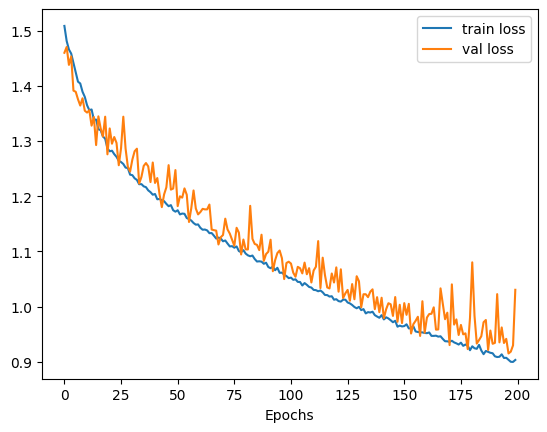

In [24]:
# Unfreeze parameters and retrain

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

lr = 1e-4
nepochs = 200 # 100
momentum = .9
optimizer = torch.optim.SGD(modelFCN.parameters(), lr=lr, momentum=momentum)
early_stopper = EarlyStopping(patience=5, min_delta=1e-4)

modelFCN = modelFCN.to(device)
train_loss, val_loss = train(modelFCN, optimizer,
                             train_loader, val_loader,
                             nepochs_max=nepochs,
                             lr_scheduler=None,
                             early_stopper=early_stopper)
plot_learning_curves(train_loss, val_loss)


In [25]:
torch.save(modelFCN.state_dict(), f'{result_folder}/modelFCN8_retrained.pth')

In [26]:
train_img, train_lab = next(iter(train_loader))
train_img = train_img[0].to(device)
train_lab = train_lab[0]
print('t1', train_img.shape)

out = modelFCN(train_img.unsqueeze(0))

pred_label_map = torch.argmax(out, dim=1)
print(pred_label_map.shape)
print('pred values', pred_label_map.unique())

t1 torch.Size([3, 512, 512])
torch.Size([1, 512, 512])
pred values tensor([0, 1, 2, 3, 4, 5, 6], device='cuda:0')


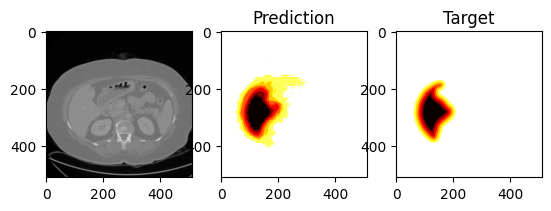

In [27]:
plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(train_img.permute(1, 2, 0).cpu())

plt.subplot(1, 3, 2)
plt.imshow(pred_label_map.squeeze().detach().cpu(), cmap='hot')
plt.title('Prediction')

plt.subplot(1, 3, 3)
plt.imshow(train_lab, cmap='hot')
plt.title('Target')


plt.show()

## ACM

In [28]:
def get_predicted_labelmap(output : torch.tensor, nclass=7) -> np.ndarray:
  """
  Convert model's output with value in {0, nclass-1} to value in {-n/2, ..., 0, ..., n/2}
  corresponding to layer index
  :param output: model's output of size (1, nclass, H, W)
  """
  pred_label_map = torch.argmax(output, dim=1)
  t = int((nclass-1)/2)
  return (pred_label_map - t).detach().numpy()

In [29]:
# !git clone https://github.com/TheoBertrand-Dauphine/MVA_NT_geodesic_methods

In [30]:
# !pip install scikit-fmm # for re-distancing

In [31]:
# import MVA_NT_geodesic_methods.nt_toolbox.grad as toolgrad
# import MVA_NT_geodesic_methods.nt_toolbox.div as tooldiv

# from MVA_NT_geodesic_methods.nt_toolbox.general import toolgeneral
# from MVA_NT_geodesic_methods.nt_toolbox.signal import toolsignal

# from MVA_NT_geodesic_methods.nt_toolbox.perform_redistancing import perform_redistancing

In [32]:
# # Extract initial curve from FCN model output
# # saved_modelFCN = LayerFCN8()
# # saved_modelFCN.load_state_dict(torch.load(f'{result_folder}/modelFCN8.pth'))

# patient_ids = os.listdir(data_folder)
# print(patient_ids)
# label_map_folder = f"{data_folder}/{patient_ids[0]}/Layer_label_map/"
# label_map_files = os.listdir(label_map_folder)

# label_map = f"{label_map_folder}/{label_map_files[0]}"

# plt.imshow(label_map, cmap='hot')
# plt.show()

In [33]:
# curve = label_map.numpy()==0